In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.interpolate import CubicSpline
from scipy.stats import t
from IPython.display import Math
from sympy import *
alpha = 0.95
pd.set_option('future.no_silent_downcasting', True)

# Функции создания моделей

In [13]:
def addition_model_auto_reg(origin_data, n_new, text_show = False, show_tables = False):   
    def display_txt(lst):
        if type(lst)==list:
            
            for text in lst:
                try:
                    display(Math(text.replace(' ','~')))
                except:
                    display(Math(str(text)))
        else:
            try:
                display(Math(lst.replace(' ','~')))
            except:
                display(Math(str(lst)))
                
    def smooth_plot(datas = [], indices = [], xfroms = [], markers = [],last = True,dropna = True):
            
        if xfroms == []:
            xfroms = [1]*len(indices)
        
        lines = []
            
        for i in range(len(indices)):
            # Данные
            if dropna:
                y = datas[i][indices[i]].dropna().values
            else:
                y = datas[i][indices[i]].values
            x = np.arange(xfroms[i], y.size+xfroms[i], dtype = float)
            # Создание сглаживающей функции
            cs = CubicSpline(x, y)
            
            # Генерация новых точек для плавного графика
            x_smooth = np.linspace(x.min(), x.max(), 100)
            y_smooth = cs(x_smooth)
            
            if len(markers):
                plt.plot(x, y, markers[i]+'o')  # Оригинальные точки
                lines.append(plt.plot(x_smooth, y_smooth, markers[i]+'-', alpha = 0.5, label = indices[i]))  # Сглаженный график
            
            
        if last:
            plt.legend()
            plt.grid()
            plt.show()
    
    def bar_plot_dict(r:dict):
        # Данные для коррелограммы
        lags = r.keys()
        correlations = r.values()

        # Создание графика
        fig, ax = plt.subplots()
        bars = ax.bar(lags, correlations, color='lightblue')

        # Добавление значений на вершины столбцов
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 8), ha='center', va='bottom')

        # Настройка осей и заголовков
        ax.set_xlabel('Лаг')
        ax.set_ylabel('Корреляция')
        ax.set_ylim(0, 0.6)

        # Отображение графика
        plt.show()
    
    
    y = origin_data.values.ravel()
    
    n_new = origin_data.shape[1] * n_new
    display_txt(n_new)
    data = pd.DataFrame(origin_data.values.ravel().reshape(-1,1),index=pd.RangeIndex(1,origin_data.values.size+1,name='t'),columns=['y_t'])
    
    if show_tables:
        display(data)
    
    
    data['(y_t - _y)**2'] = (data['y_t'] - data['y_t'].mean())**2
    r = dict()
    for i in range(1,n_new+1):
        data[f'y_t-{i}'] =data['y_t'].shift(i)
        data[f'{i}'] = (data['y_t'] - data['y_t'].mean())*(data[f'y_t-{i}'] - data['y_t'].mean())
        r[f'{i}'] = data[f'{i}'].sum()/data['(y_t - _y)**2'].sum()
    
    
    
    if text_show:
        display_txt(
        '''Для выявления структуры имеющегося временного ряда проведем автокорреляционный анализ.
        Пользуясь данными итоговой строки таблицы,
        рассчитаем коэффициенты автокорреляции 1-го, 2-го, 3-го и 4-го порядков. '''.split('\n')
    )
    if show_tables:
        display(data)
    
    bar_plot_dict(r)
    
    
    txt1_1 = f'''Из графика коррелограммы и значений коэффициентов автокорреляции видно,
    что наиболее тесная связь наблюдается при временном лаге {n_new} при умеренном коэффициенте
    автокорреляции 1-го порядка. Из этого следует, что во временном ряду наряду с тенденцией
    T присутствуют сезонные колебания S с периодичностью в {n_new} квартала, то есть характер
    динамики инвестиций в основной капитал ежегодно повторяется.
    Данные предположения также подтверждаются графиком динамики
    наблюдаемых значений исследуемого показателя '''
    if text_show:
        display_txt(txt1_1.split('\n'))
    
    
    
    smooth_plot([data],['y_t'],[1],['b'])
    
    txt1 = '''Из графика поквартальной динамики инвестиций в основной капитал видно,
    что амплитуда колебаний постепенно увеличивается, следовательно,
    для моделирования такого временного ряда, целесообразнее использовать мультипликативную модель.
    Впоследствии данный факт будет доказан сравнением показателей качества аддитивной и мультипликативной моделей.  
    Как было сказано выше, построение аддитивной и мультипликативной моделей производится в шесть шагов.
    Для начала построим аддитивную модель. '''
    if text_show:
        display_txt(txt1.split('\n'))
    
    if text_show:
        display_txt(' Произведем выравнивание исходного временного ряда с помощью скользящей средней ')
    data2 = pd.DataFrame(y.reshape(-1,1), columns=['y_t'])

    
    k4 =[]
    yc_t = []
    for i in range(y.size - (n_new-1)):
        k4.append(sum([y[i+j] for j in range(n_new)]))
        yc_t.append(sum([y[i+j] for j in range(n_new)])/n_new)
        
    
    
    data2['4k'] = [pd.NA]*(n_new//2) + k4 + [pd.NA]*(n_new - n_new//2 - 1)
    data2['yc_t'] = [pd.NA]*(n_new//2) + yc_t + [pd.NA]*(n_new - n_new//2 - 1)
    data2['_ycc_t'] = [pd.NA]*(n_new//2) + [(data2['yc_t'][i]+data2['yc_t'][i+1])/2 for i in range(n_new//2,y.size-n_new//2 - n_new%2)] + [pd.NA]*(n_new - n_new//2)
    data2['mark'] = (data2['y_t'] - data2['_ycc_t'])

    if show_tables: 
        display(data2)
    if text_show:
        display_txt('Произведя подобные преобразования, мы сгладили имевшиеся в исходном временном ряду t y сезонные колебания, что хорошо заметно на рисунке:')        
    smooth_plot([data,data2],['y_t','yc_t'], [1,3],['b','m'])
    
    txt2='''Шаг 2. Найдем оценки сезонной компоненты как разность между фактическими уровнями ряда t y
    и центрированными скользящими средними cц t y .
    Далее перенесем полученные разности  в таблицу согласно соответствующему году и кварталу.'''
    if text_show:
        display_txt(txt2.split('\n'))
    marks = data2['mark'].fillna(0).values.reshape(*origin_data.shape).astype(float)
    if show_tables:
        display(marks)
    
    _S_i = marks.sum(axis=0)/np.count_nonzero(marks,0)
    
    _S_i
    txt2_l_5 = 'Затем рассчитаем средние оценки сезонных колебаний S по всем годам для каждого квартала в отдельности: '
    display_txt([txt2_l_5]+list(_S_i))
    
    _S = (_S_i).sum()
    
    txt2_l_4 = """При моделировании периодических колебаний обычно предполагается,
    что сезонные воздействия за период взаимопогашаются. В аддитивной модели это выражается в том,
    что сумма значений сезонной компоненты по всем кварталам должна быть равна нулю. В нашем же случае: """
    display_txt(txt2_l_4.split('\n')+[_S])
    
    k = _S/origin_data.shape[0]
    
    txt2_l_3 = '''Для устранения данного противоречия скорректируем полученные
    средние значения оценок сезонной компоненты S таким образом.
    Величина корректирующего коэффициента будет следующей:  '''
    display_txt(txt2_l_3.split('\n')+[k])
    
    d_S_i = _S_i - k
    d_S_i
    
    txt2_l_2 = 'Теперь рассчитаем скорректированные значения сезонной компоненты S как &&& разность между ее средней оценкой S и корректирующим коэффициентом k: '
    display_txt(txt2_l_2.split('&&&') + list(d_S_i))
    
    
    
    txt2_l_1 = 'Проверим условие взаимопогашаемости значений сезонной компоненты: '
    display_txt([txt2_l_1,f'{d_S_i.sum()}' +r' \approx 0'])
    
    
    txt2_l = 'Перенесем полученные значения S в таблицу напротив соответствующих кварталов каждого года.'
    display_txt(txt2_l)
    
    data3 = pd.DataFrame(data.loc[:,'y_t'])
    data3['S'] = list(d_S_i)*origin_data.shape[0]
    if show_tables:
        display(data3)
    
    
    
    txt3='''Шаг 3. Исключим влияние сезонной компоненты S, вычитая ее соответствующие значения S из каждого уровня исходного временного ряда t y. 
    Таким образом получим:  T + E = Yt – S.
    Эти значения рассчитываются для каждого момента времени и содержат только тенденцию T  и случайную компоненту E. 
    '''
    if text_show:
        display_txt(txt3.split('\n'))
    
    data3['T+E'] = data3['y_t'] - data3['S']
    if show_tables:
        display(data3)

    b0, b1 = symbols('b0 b1')

    # Запись уравнений системы
    eq1 = Eq(data3.index.size * b0 + pd.Series(data3.index).sum() * b1, data3['T+E'].sum())
    eq2 = Eq(pd.Series(data3.index).sum() * b0 + (pd.Series(data3.index)**2).sum() * b1, (data3.index*data3['T+E']).sum())

    # Решение системы уравнений
    solution = solve((eq1, eq2), (b0, b1))

    # Вывод решения
    print("b0 =", solution[b0])
    print("b1 =", solution[b1])
    b0 = float(solution[b0])
    b1 = float(solution[b1])
    
    
    
    data3['T'] = pd.Series(b0 + np.arange(0,data.shape[0] +1)*b1)
    data3['T+S'] = data3['T']+data3['S']
    
    if show_tables:
        display(data3)       
    
    smooth_plot([data3]*4,['y_t','T+E','T','T+S'],markers=['b','m','y','c'])
    
    data['e_t'] =  data['y_t'] - data3['T+S']
    data4 = pd.DataFrame(data.loc[:,'e_t'])
    data4['(dyt - _y_t)**2'] = (data3['T+S'] - data['y_t'].mean())**2
    data4['(y_t - dyt)**2'] = (data3['T+S'] - data['y_t'])**2
    data4['|y_t - dyt|/y_t'] = np.abs(data3['T+S'] - data['y_t'])/data['y_t'] * 100
    
    if show_tables:
        display(data4)
    
    if text_show:
        display_txt('В оцененном виде аддитивную модель изучаемого временного ряда можно представить следующим образом: ')
    
    display_txt(f'y = {b0} + {b1}' + r'\times t + \hat{S_i} + e_t')
    
    display_txt(r'\hat{S_i} = ' + f'{list(d_S_i)}')
    
    def hat_y(t):
        return b0 + b1*t + d_S_i[t%len(d_S_i)-1]

    h_y = np.vectorize(hat_y)


    predicted = h_y(range(data.shape[0] +1 ,data.shape[0] +1 + n_new))

    display_txt(['\nПредсказанные значения:\n', *predicted])
    
    
    S_e = np.sqrt(data4['(y_t - dyt)**2'].sum()/(data.shape[0] - 1 - 1))
    
    display_txt(f'\nРассчитаем стандартную ошибку регрессии: {S_e}\n')
    
    
    def s_e(t):
        return S_e * np.sqrt(1 + 1/data.shape[0] + (t - np.mean(data.index))**2/np.sum((data.index - np.mean(data.index))**2))

    std = np.vectorize(s_e)


    errors = std(range(data.shape[0] +1 ,data.shape[0] +1 + n_new))

    display_txt(['\nCтандартные ошибки прогноза будут следующими:\n',*errors])
    
    # Нахождение критического значения t
    degrees_of_freedom = data.shape[0] - 2
    t_critical = t.ppf(1 - (1 - alpha) / 2, degrees_of_freedom)
    
    lower_boarder = (h_y(range(data.shape[0] +1 ,data.shape[0] +1 + n_new)) - std(range(data.shape[0] +1 ,data.shape[0] +1 + n_new)) * t_critical)
    upper_boarder = (h_y(range(data.shape[0] +1 ,data.shape[0] +1 + n_new)) + std(range(data.shape[0] +1 ,data.shape[0] +1 + n_new)) * t_critical)

    display_txt(f"\nКритическое значение t_{{0.95;{degrees_of_freedom}}} = {t_critical:.2f}\n")
    
    
    data5 = pd.DataFrame(np.hstack((data3.iloc[:,4].values,predicted)),columns =['predict'])
    
    
    
    data6 = pd.DataFrame(np.vstack((lower_boarder, upper_boarder)).T, columns=['lower_boarder','upper_boarder'])
    if show_tables:
        display(data6)
    
    smooth_plot([data3,data5,data6,data6],['y_t','predict','lower_boarder','upper_boarder'],[1,1,data.shape[0]+1,data.shape[0]+1],markers=['m','c','y','r'])
    
    
    R2 = data4['(dyt - _y_t)**2'].sum()/(data4['(dyt - _y_t)**2'].sum() + data4['(y_t - dyt)**2'].sum())
    display_txt(['- коэффициент детерминации',R2])
    
    A_ = data4['|y_t - dyt|/y_t'].mean()
    display_txt(['- средняя ошибка аппроксимации', f'{A_}%'])
 

In [14]:
def multiplication_model_auto_reg(origin_data, n_new, text_show = False, show_tables = False):   
    def display_txt(lst):
        if type(lst)==list:
            
            for text in lst:
                try:
                    display(Math(text.replace(' ','~')))
                except:
                    display(Math(str(text)))
        else:
            try:
                display(Math(lst.replace(' ','~')))
            except:
                display(Math(str(lst)))
                
    def smooth_plot(datas = [], indices = [], xfroms = [], markers = [],last = True,dropna = True):
            
        if xfroms == []:
            xfroms = [1]*len(indices)
        
        lines = []
            
        for i in range(len(indices)):
            # Данные
            if dropna:
                y = datas[i][indices[i]].dropna().values
            else:
                y = datas[i][indices[i]].values
            x = np.arange(xfroms[i], y.size+xfroms[i], dtype = float)
            # Создание сглаживающей функции
            cs = CubicSpline(x, y)
            
            # Генерация новых точек для плавного графика
            x_smooth = np.linspace(x.min(), x.max(), 100)
            y_smooth = cs(x_smooth)
            
            if len(markers):
                plt.plot(x, y, markers[i]+'o')  # Оригинальные точки
                lines.append(plt.plot(x_smooth, y_smooth, markers[i]+'-', alpha = 0.5, label = indices[i]))  # Сглаженный график
            
            
        if last:
            plt.legend()
            plt.grid()
            plt.show()
    
    def bar_plot_dict(r:dict):
        # Данные для коррелограммы
        lags = r.keys()
        correlations = r.values()

        # Создание графика
        fig, ax = plt.subplots()
        bars = ax.bar(lags, correlations, color='lightblue')

        # Добавление значений на вершины столбцов
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 8), ha='center', va='bottom')

        # Настройка осей и заголовков
        ax.set_xlabel('Лаг')
        ax.set_ylabel('Корреляция')
        ax.set_ylim(0, 0.6)

        # Отображение графика
        plt.show()
    
    
    y = origin_data.values.ravel()
    
    n_new = origin_data.shape[1] * n_new
    display_txt(n_new)
    data = pd.DataFrame(origin_data.values.ravel().reshape(-1,1),index=pd.RangeIndex(1,origin_data.values.size+1,name='t'),columns=['y_t'])
    
    if show_tables:
        display(data)
    
    
    data['(y_t - _y)**2'] = (data['y_t'] - data['y_t'].mean())**2
    r = dict()
    for i in range(1,n_new+1):
        data[f'y_t-{i}'] =data['y_t'].shift(i)
        data[f'{i}'] = (data['y_t'] - data['y_t'].mean())*(data[f'y_t-{i}'] - data['y_t'].mean())
        r[f'{i}'] = data[f'{i}'].sum()/data['(y_t - _y)**2'].sum()
    
    
    
    if text_show:
        display_txt(
        '''Для выявления структуры имеющегося временного ряда проведем автокорреляционный анализ.
        Пользуясь данными итоговой строки таблицы,
        рассчитаем коэффициенты автокорреляции 1-го, 2-го, 3-го и 4-го порядков. '''.split('\n')
    )
    if show_tables:
        display(data)
    
    bar_plot_dict(r)
    
    
    txt1_1 = f'''Из графика коррелограммы и значений коэффициентов автокорреляции видно,
    что наиболее тесная связь наблюдается при временном лаге {n_new} при умеренном коэффициенте
    автокорреляции 1-го порядка. Из этого следует, что во временном ряду наряду с тенденцией
    T присутствуют сезонные колебания S с периодичностью в {n_new} квартала, то есть характер
    динамики инвестиций в основной капитал ежегодно повторяется.
    Данные предположения также подтверждаются графиком динамики
    наблюдаемых значений исследуемого показателя '''
    if text_show:
        display_txt(txt1_1.split('\n'))
    
    
    
    smooth_plot([data],['y_t'],[1],['b'])
    
    txt1 = '''Из графика поквартальной динамики инвестиций в основной капитал видно,
    что амплитуда колебаний постепенно увеличивается, следовательно,
    для моделирования такого временного ряда, целесообразнее использовать мультипликативную модель.
    Впоследствии данный факт будет доказан сравнением показателей качества аддитивной и мультипликативной моделей.  
    Как было сказано выше, построение аддитивной и мультипликативной моделей производится в шесть шагов.
    Для начала построим аддитивную модель. '''
    if text_show:
        display_txt(txt1.split('\n'))
    
    if text_show:
        display_txt(' Произведем выравнивание исходного временного ряда с помощью скользящей средней ')
    data2 = pd.DataFrame(y.reshape(-1,1), columns=['y_t'])

    
    k4 =[]
    yc_t = []
    for i in range(y.size - (n_new-1)):
        k4.append(sum([y[i+j] for j in range(n_new)]))
        yc_t.append(sum([y[i+j] for j in range(n_new)])/n_new)
        
    
    
    data2['4k'] = [pd.NA]*(n_new//2) + k4 + [pd.NA]*(n_new - n_new//2 - 1)
    data2['yc_t'] = [pd.NA]*(n_new//2) + yc_t + [pd.NA]*(n_new - n_new//2 - 1)
    data2['_ycc_t'] = [pd.NA]*(n_new//2) + [(data2['yc_t'][i]+data2['yc_t'][i+1])/2 for i in range(n_new//2,y.size-n_new//2 - n_new%2)] + [pd.NA]*(n_new - n_new//2)
    data2['mark'] = (data2['y_t']/data2['_ycc_t'])

    if show_tables:
        display(data2)
    if text_show:
        display_txt('Произведя подобные преобразования, мы сгладили имевшиеся в исходном временном ряду t y сезонные колебания, что хорошо заметно на рисунке:')        
    smooth_plot([data,data2],['y_t','yc_t'], [1,3],['b','m'])
    
    txt2='''Шаг 2. Найдем оценки сезонной компоненты как частное от деления фактических уровней
    ряда t y на центрированные скользящие средние cц t y. 
    Далее рассчитаем средние значения сезонных колебаний для каждого квартала i S.
    Для этого перенесем имеющиеся оценки в таблицу'''
    if text_show:
        display_txt(txt2.split('\n'))
    marks = data2['mark'].fillna(0).values.reshape(*origin_data.shape).astype(float)
    if show_tables:
        display(marks)
    
    _S_i = marks.sum(axis=0)/np.count_nonzero(marks,0)
    
    txt2_l_5 = '''Взаимопогашаемость сезонных воздействий в мультипликативной модели выражается в том,
    что сумма значений i S сезонной компоненты S должна быть равна числу периодов в цикле,
    то есть для данного примера – четырем. Суммируя i S , получаем:  '''
    
    _S = (_S_i).sum()

    display_txt(txt2_l_5.split('\n')+list(_S_i) +['\n',_S])
    
    k = origin_data.shape[0]/_S
    
    txt2_l_3 = '''Рассчитаем корректирующий коэффициент:  
    '''
    display_txt(txt2_l_3.split('\n')+[k])
    
    d_S_i = _S_i*k
    
    display_txt(
        '''Определим скорректированные значения сезонной компоненты,
        умножив ее средние оценки i S на корректирующий коэффициент k: '''.split('\n')+ list(d_S_i)
    )
    
    display_txt('''Проверим выполнение свойства взаимопогашаемости сезонных колебаний в мультипликативной модели: '''.split('\n') +[np.sum(d_S_i)])

    display_txt('''Для выполнения последующих расчетов перенесем полученные значения S в таблицу в соответствии с каждым кварталом. ''')
    
    data3 = pd.DataFrame(data.loc[:,'y_t'])
    data3['S'] = list(d_S_i)*origin_data.shape[0]
    if show_tables:
        display(data3)
    
    txt3='''Шаг 3. Исключим из исходного временного ряда сезонные колебания,
    разделив каждый уровень t y на соответствующее значение i S.
    В итоге получим временной ряд, содержащий только тенденцию T и случайную компоненту E. '''
    if text_show:
        display_txt(txt3.split('\n'))
    
    data3['TE'] = data3['y_t']/data3['S']
    if show_tables:
        display(data3)
    
    b0, b1 = symbols('b0 b1')

    # Запись уравнений системы
    eq1 = Eq(data3.index.size * b0 + pd.Series(data3.index).sum() * b1, data3['TE'].sum())
    eq2 = Eq(pd.Series(data3.index).sum() * b0 + (pd.Series(data3.index)**2).sum() * b1, (data3.index*data3['TE']).sum())

    # Решение системы уравнений
    solution = solve((eq1, eq2), (b0, b1))

    # Вывод решения
    print("b0 =", solution[b0])
    print("b1 =", solution[b1])
    b0 = float(solution[b0])
    b1 = float(solution[b1])
    
    data3['T'] = pd.Series(b0 + np.arange(0,data.shape[0] +1)*b1)
    data3['TS'] = data3['T']*data3['S']
    smooth_plot([data3]*4,['y_t','TE','T','TS'],markers=['b','m','y','c'])
    
    data['e_t'] =  data['y_t']-data3['TS']
    
    if show_tables:
        display(data3)
    if text_show:
        display_txt('Таким образом, мультипликативную модель изучаемого временного ряда можно представить следующим образом: ')
    
    display_txt(f'y = ({b0} + {b1}' + r'\times t)\times \hat{S_i} \times e_t')
    
    data4 = pd.DataFrame(data.loc[:,'e_t'])
    data4['(dyt - _y_t)**2'] = (data3['TS'] - data['y_t'].mean())**2
    data4['(y_t - dyt)**2'] = (data3['TS'] - data['y_t'])**2
    data4['|y_t - dyt|/y_t'] = np.abs(data3['TS'] - data['y_t'])/data['y_t'] * 100
    
    display_txt(
        '''Для расчета показателей качества модели значения отн t e 
        относительной ошибки E  не могут быть использованы.
        Поэтому для оценки качества модели необходимо рассчитать значения
        абсолютной ошибки по формуле Eабс=Yt - (T·S), то есть )
        Значения остатков t e представлены в графе 1. 
        '''.split('\n')
    )
    if show_tables:
        display(data4)
    
    display_txt(r'\hat{S_i} = ' + f'{list(d_S_i)}')
    
    def hat_y(t):
        return (b0 + b1*t)* d_S_i[t%len(d_S_i)-1]

    h_y = np.vectorize(hat_y)


    predicted = h_y(range(data.shape[0] +1 ,data.shape[0] +1 + n_new))

    display_txt(['\nПредсказанные значения:\n', *predicted])
    
    
    S_e = np.sqrt(data4['(y_t - dyt)**2'].sum()/(data.shape[0] - 1 - 1))
    
    display_txt(f'\nРассчитаем стандартную ошибку регрессии: {S_e}\n')
    
    
    def s_e(t):
        return S_e * np.sqrt(1 + 1/data.shape[0] + (t - np.mean(data.index))**2/np.sum((data.index - np.mean(data.index))**2))

    std = np.vectorize(s_e)


    errors = std(range(data.shape[0] +1 ,data.shape[0] +1 + n_new))

    display_txt(['\nCтандартные ошибки прогноза будут следующими:\n',*errors])
    
    # Нахождение критического значения t
    degrees_of_freedom = data.shape[0] - 2
    t_critical = t.ppf(1 - (1 - alpha) / 2, degrees_of_freedom)
    
    lower_boarder = (h_y(range(data.shape[0] +1 ,data.shape[0] +1 + n_new)) - std(range(data.shape[0] +1 ,data.shape[0] +1 + n_new)) * t_critical)
    upper_boarder = (h_y(range(data.shape[0] +1 ,data.shape[0] +1 + n_new)) + std(range(data.shape[0] +1 ,data.shape[0] +1 + n_new)) * t_critical)

    display_txt(f"\nКритическое значение t_{{0.95;{degrees_of_freedom}}} = {t_critical:.2f}\n")
    
    data5 = pd.DataFrame(np.hstack((data3.iloc[:,4].values,predicted)),columns =['predict'])
    
    
    
    data6 = pd.DataFrame(np.vstack((lower_boarder, upper_boarder)).T, columns=['lower_boarder','upper_boarder'])
    if show_tables:
        display(data6)
    
    smooth_plot([data3,data5,data6,data6],['y_t','predict','lower_boarder','upper_boarder'],[1,1,data.shape[0]+1,data.shape[0]+1],markers=['m','c','y','r'])
    
    R2 = data4['(dyt - _y_t)**2'].sum()/(data4['(dyt - _y_t)**2'].sum() + data4['(y_t - dyt)**2'].sum())
    display_txt(['- коэффициент детерминации',R2])
    
    A_ = data4['|y_t - dyt|/y_t'].mean()
    display_txt(['- средняя ошибка аппроксимации', f'{A_}%'])
    


# Доход

In [15]:
revenue = '''5,7 6,8 8,7
5,8 6,7 8,7
5,9 6,8 8,9
6 7 9
6 7,1 9,1
6,1 7,3 9,3
6,2 7,5 9,4
6,3 7,6 9,6
6,4 7,8 9,7
6,5 8 9,9
6,6 8,2 10,1
6,7 8,4 10,1'''

revenue = np.array(list(map(lambda x: list(map(float,(x.replace(',','.').split()))), revenue.split('\n'))))
revenue = pd.DataFrame(revenue, columns=[2005,2006,2007],index=list(range(1,13)))
revenue = revenue.T
revenue

,1,2,3,4,5,6,7,8,9,10,11,12
2005,5.7,5.8,5.9,6.0,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7
2006,6.8,6.7,6.8,7.0,7.1,7.3,7.5,7.6,7.8,8.0,8.2,8.4
2007,8.7,8.7,8.9,9.0,9.1,9.3,9.4,9.6,9.7,9.9,10.1,10.1


In [16]:
revenue.to_excel('revenue.xlsx')

<IPython.core.display.Math object>

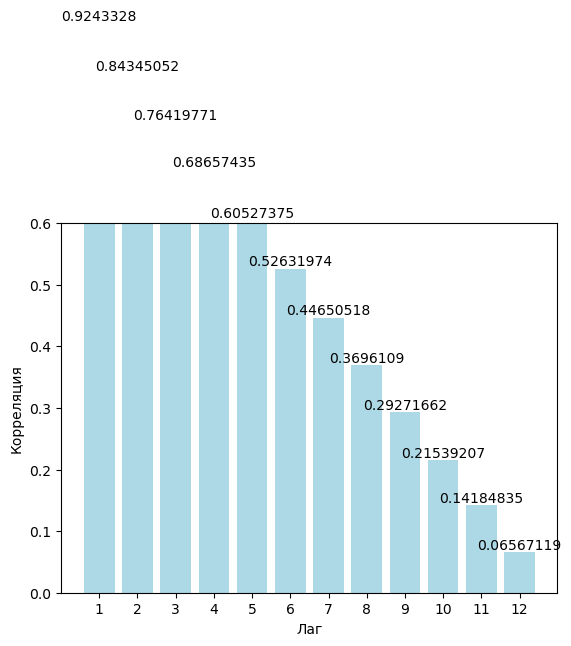

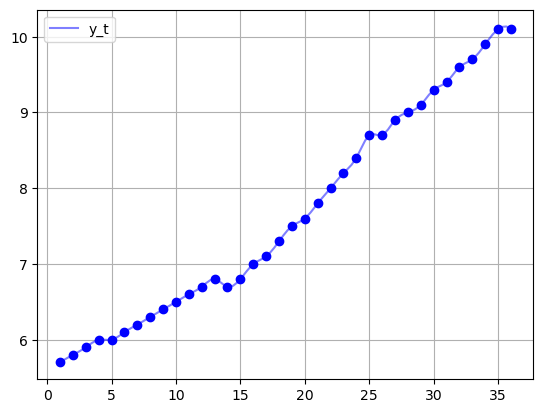

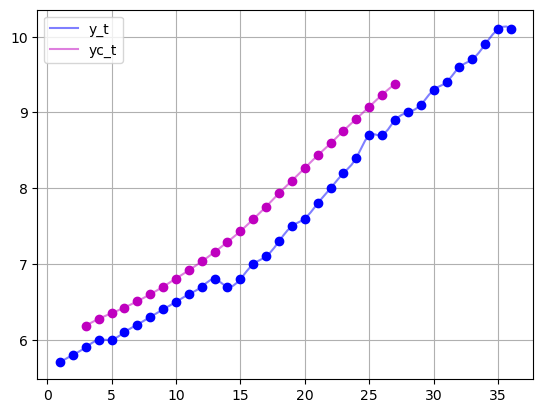

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 5.17609126984127
b1 = 0.132195141570142


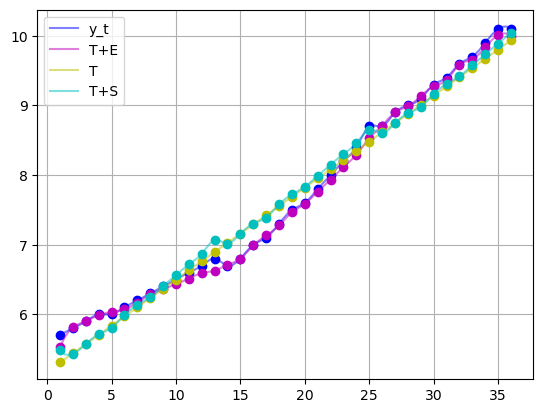

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

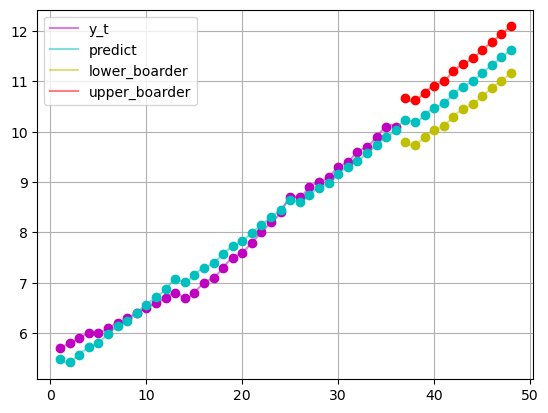

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [17]:
addition_model_auto_reg(revenue, 1, False)

<IPython.core.display.Math object>

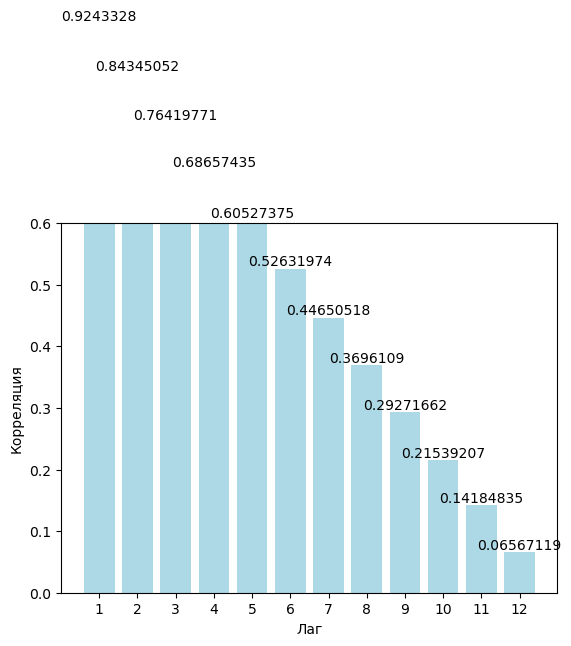

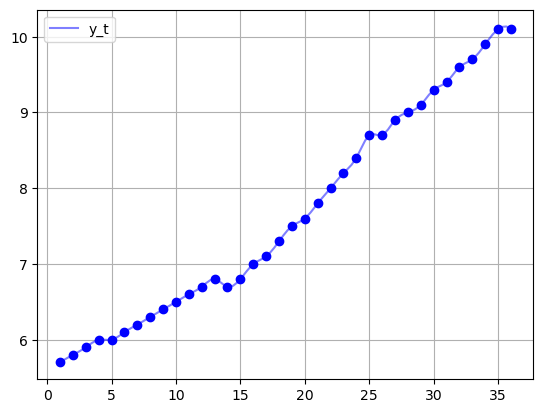

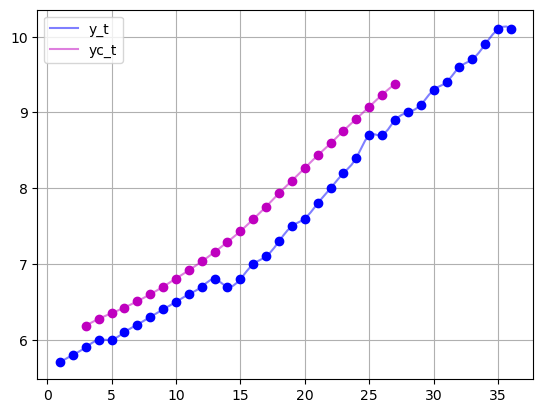

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 20.8858922386229
b1 = 0.527919084310927


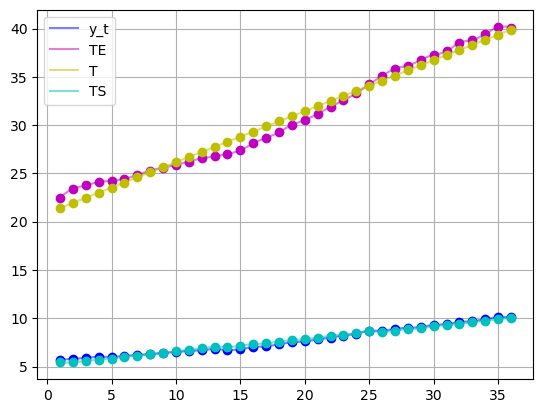

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

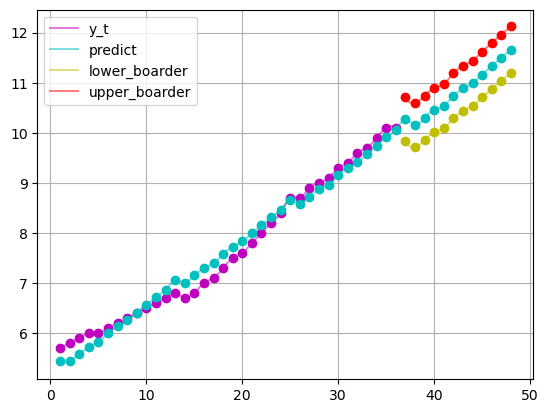

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
multiplication_model_auto_reg(revenue, 1, False)

# Организации

In [19]:
organizations = '''244 207 141
241 202 136 
237 196 131
235 190 126 
232 184 121 
229 179 116 
227 173 112 
222 167 108 
219 162 104 
215 156 100 
212 151 96 
210 145 93 '''

organizations = np.array(list(map(lambda x: list(map(float,(x.replace(',','.').split()))), organizations.split('\n'))))
organizations = pd.DataFrame(organizations, columns=[2005,2006,2007],index=list(range(1,13)))
organizations = organizations.T
organizations

,1,2,3,4,5,6,7,8,9,10,11,12
2005,244.0,241.0,237.0,235.0,232.0,229.0,227.0,222.0,219.0,215.0,212.0,210.0
2006,207.0,202.0,196.0,190.0,184.0,179.0,173.0,167.0,162.0,156.0,151.0,145.0
2007,141.0,136.0,131.0,126.0,121.0,116.0,112.0,108.0,104.0,100.0,96.0,93.0


In [20]:
organizations.to_excel('organizations.xlsx')

<IPython.core.display.Math object>

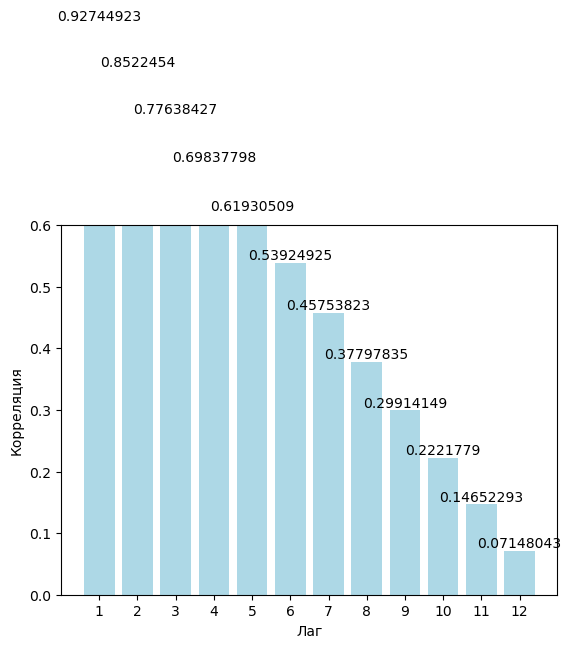

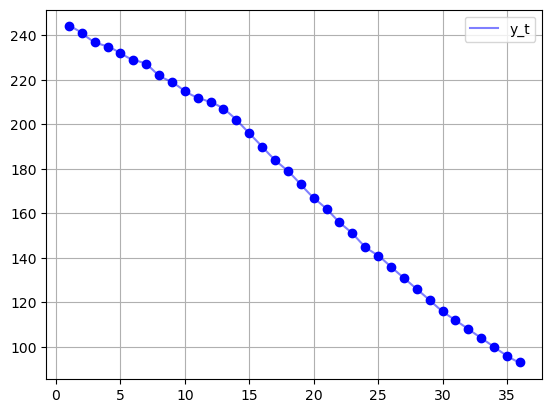

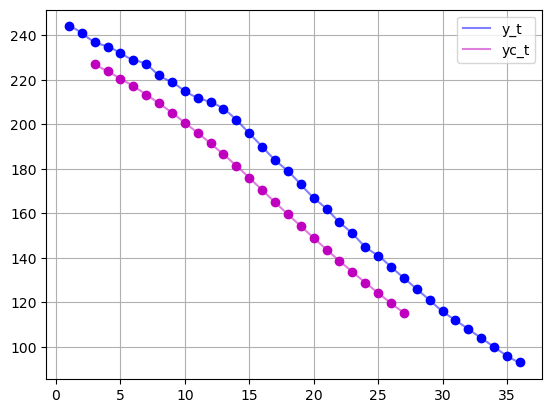

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 258.924107142857
b1 = -4.60653957528958


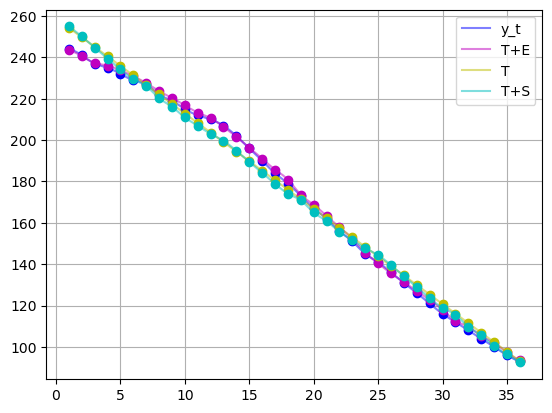

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

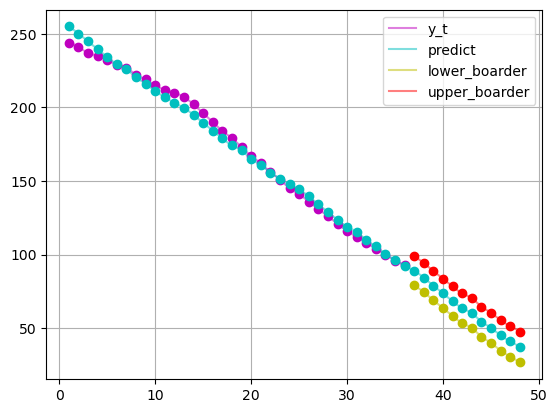

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
addition_model_auto_reg(organizations, 1, False)

<IPython.core.display.Math object>

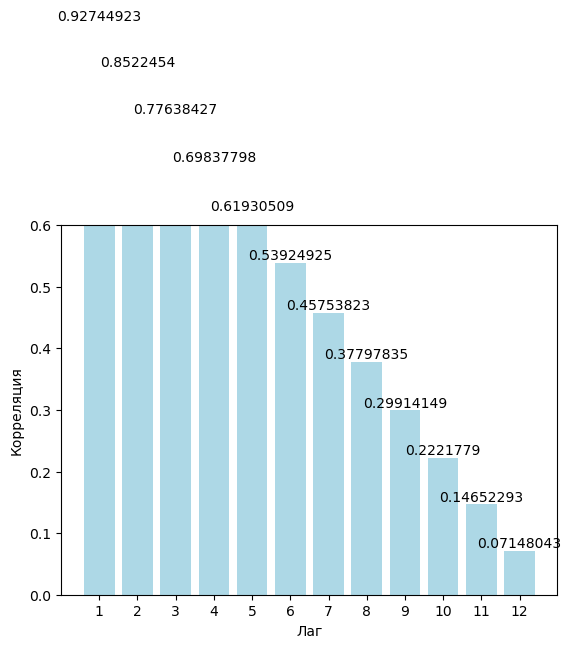

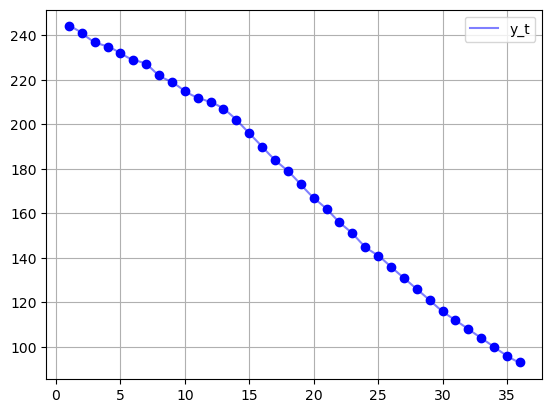

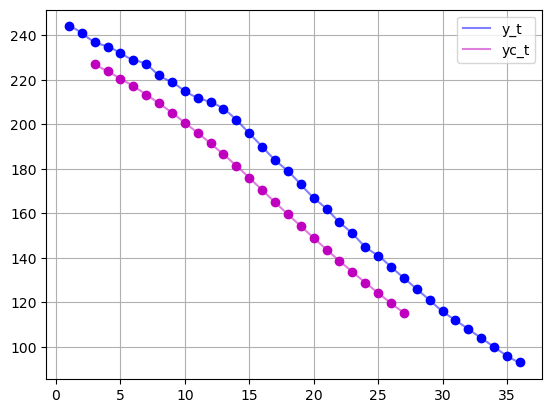

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 1031.80681088522
b1 = -18.4297811073839


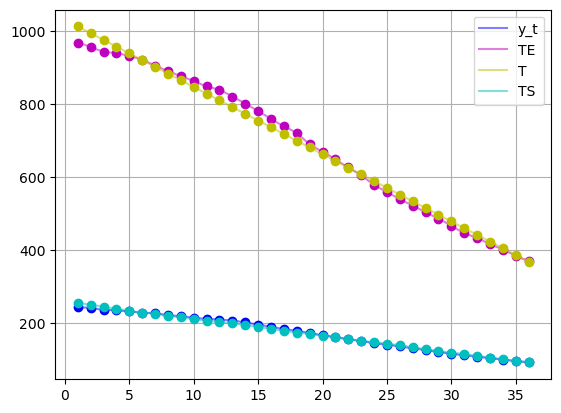

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

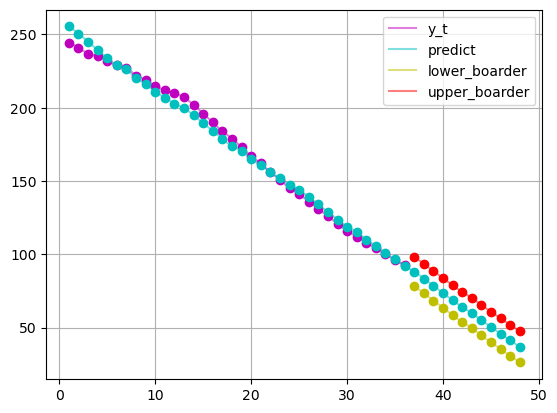

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
multiplication_model_auto_reg(organizations, 1, False)

# Поквартальная динамика оборота розничной торговли региона

In [23]:
organizations = '''317,1 380,6 444 507,4 570,8 634,3 
481,6 578 674,3 770,6 866,9 963,3 
644,4 773,3 902,1 1031 1159,9 1288,8
792,1 950,6 1109 1267,4 1425,8 1584,3 
425 510 595 680 765 850 
601 721,2 841,4 961,6 1081,8 1202  
762,8 915,3 1067,9 1220,4 1373 1525,5 
972,3 1166,7 1361,2 1555,6 1750,1 1944,5 
545,6 654,8 763,9 873 982,1 1091,3 
751,5 901,8 1052,1 1202,4 1352,7 1503  
968,8 1162,5 1356,3 1550 1743,8 1937,5 
1256 1507,2 1758,4 2009,6 2260,8 2512
647,3 776,7 906,2 1035,6 1165,1 1294,5 
647,3 776,7 906,2 1035,6 1165,1 1294,5
1237,5 1485 1732,5 1980 2227,5 2475
1641,9 1970,3 2298,6 2627 2955,4 3283,8'''

organizations = np.array(list(map(lambda x: list(map(float,(x.replace(',','.').split()))), organizations.split('\n'))))
organizations = pd.DataFrame(organizations, columns = range(1,7))
#organizations = organizations.T

organizations

,1,2,3,4,5,6
0,317.1,380.6,444.0,507.4,570.8,634.3
1,481.6,578.0,674.3,770.6,866.9,963.3
2,644.4,773.3,902.1,1031.0,1159.9,1288.8
3,792.1,950.6,1109.0,1267.4,1425.8,1584.3
4,425.0,510.0,595.0,680.0,765.0,850.0
5,601.0,721.2,841.4,961.6,1081.8,1202.0
6,762.8,915.3,1067.9,1220.4,1373.0,1525.5
7,972.3,1166.7,1361.2,1555.6,1750.1,1944.5
8,545.6,654.8,763.9,873.0,982.1,1091.3
9,751.5,901.8,1052.1,1202.4,1352.7,1503.0



                                Данные задания 1                                

--- Аддитивная модель 1_1 ---


<IPython.core.display.Math object>

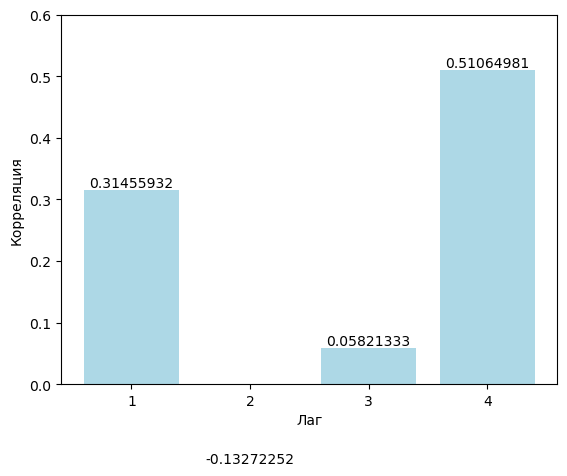

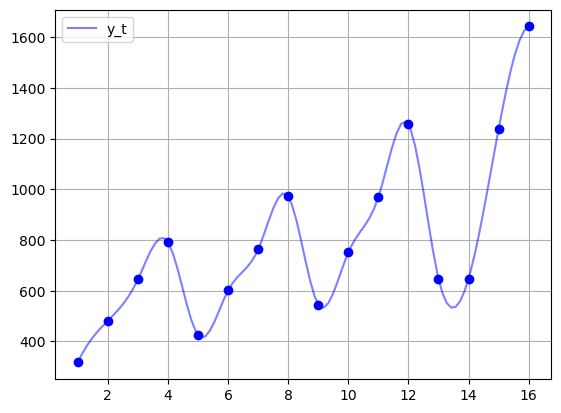

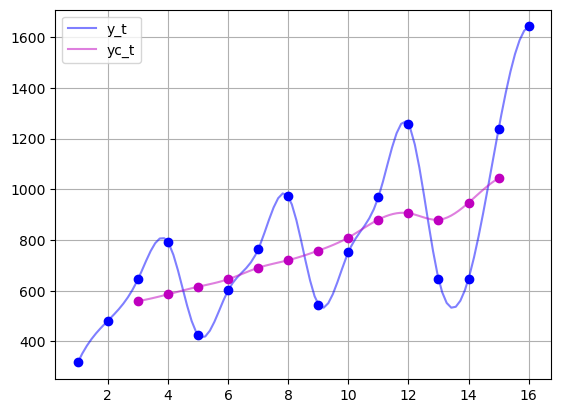

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 434.735000000000
b1 = 42.1797058823529


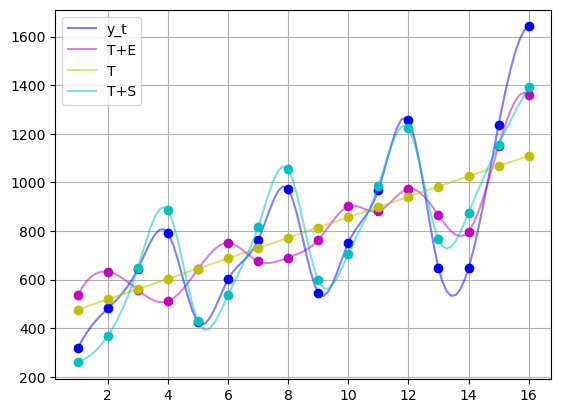

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

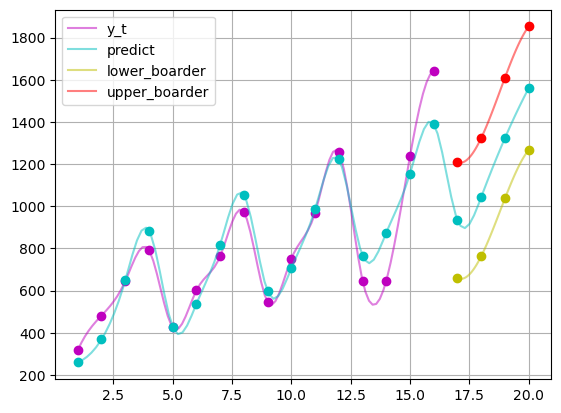

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


--- Мультипликативная модель 1_2 ---


<IPython.core.display.Math object>

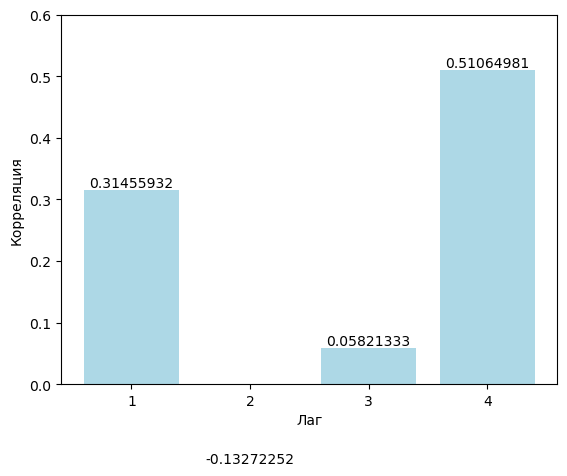

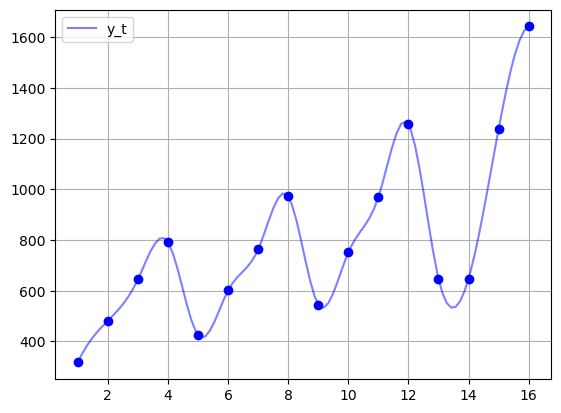

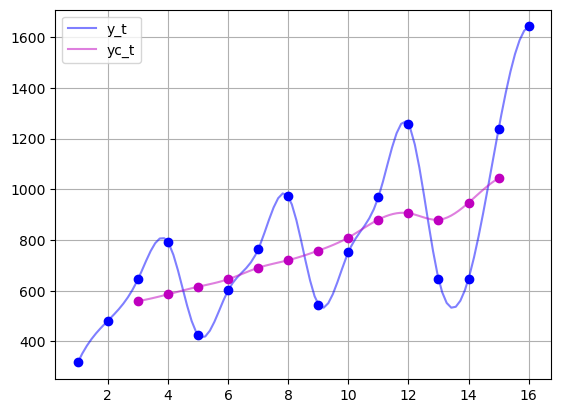

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 438.140418558105
b1 = 39.9391685664597


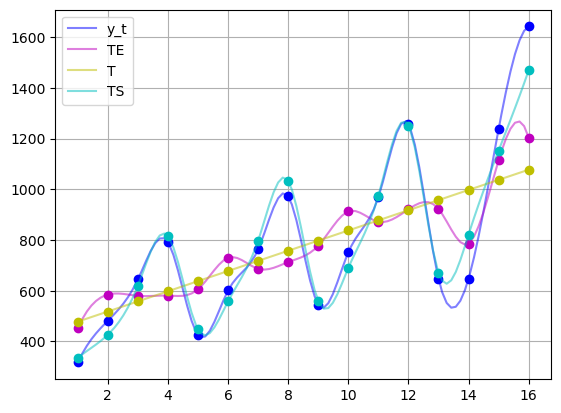

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

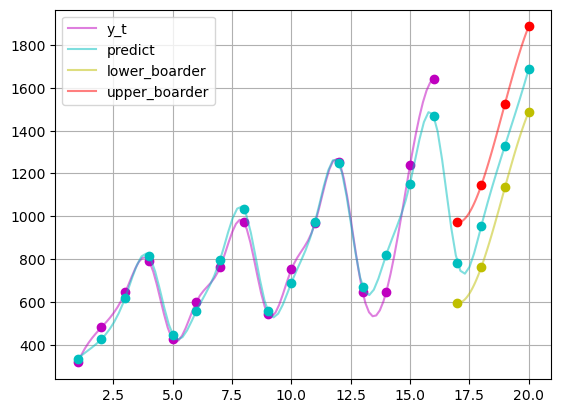

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


                                Данные задания 2                                

--- Аддитивная модель 2_1 ---


<IPython.core.display.Math object>

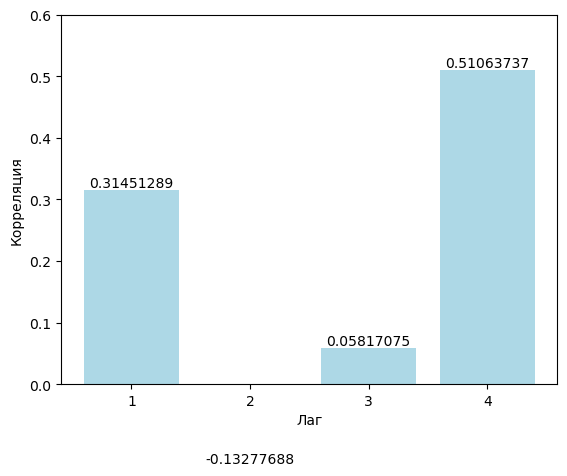

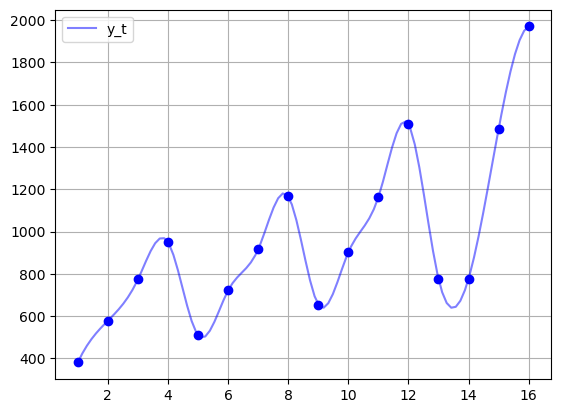

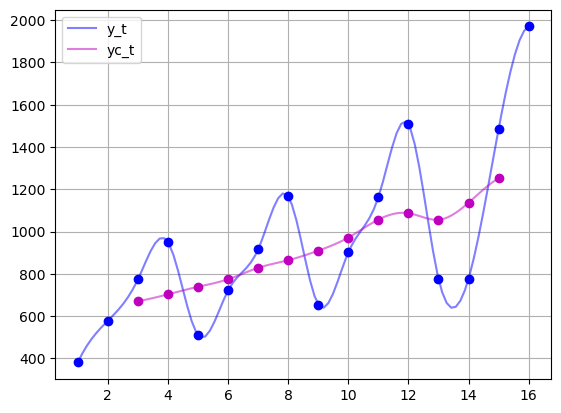

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 521.733750000000
b1 = 50.6100000000000


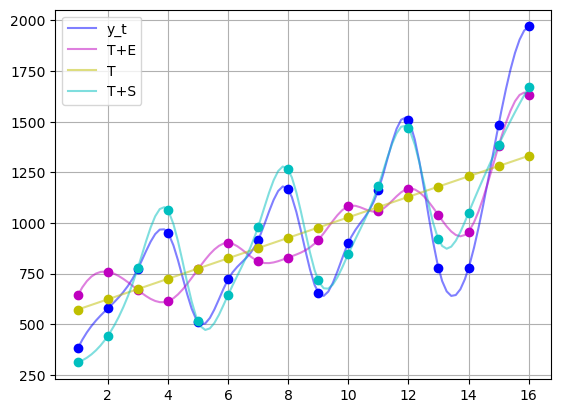

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

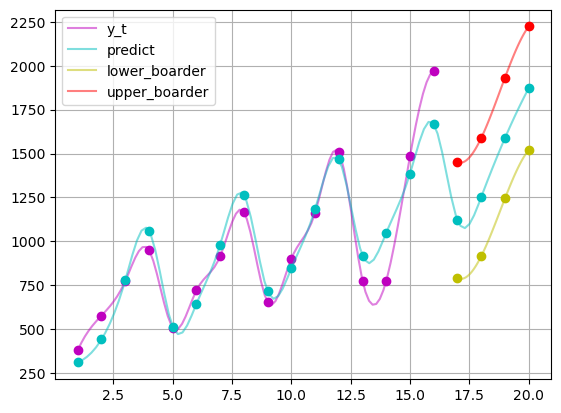

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


--- Мультипликативная модель 2_2 ---


<IPython.core.display.Math object>

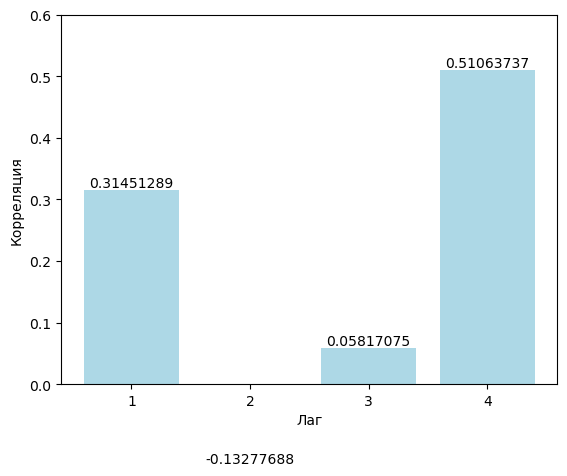

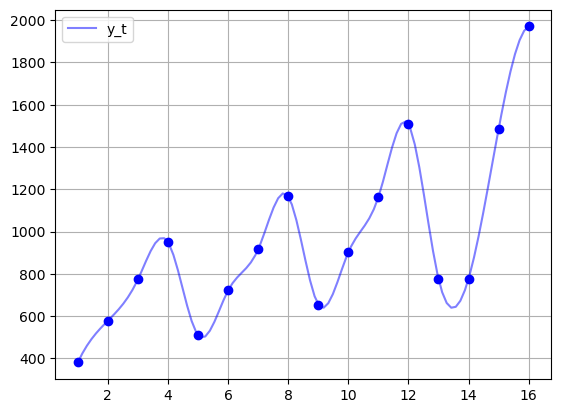

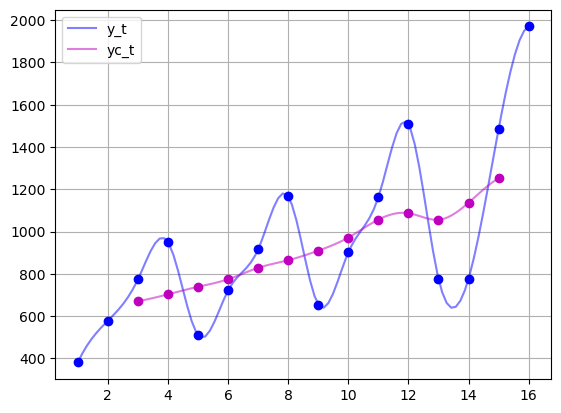

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 525.834701072655
b1 = 47.9199031902259


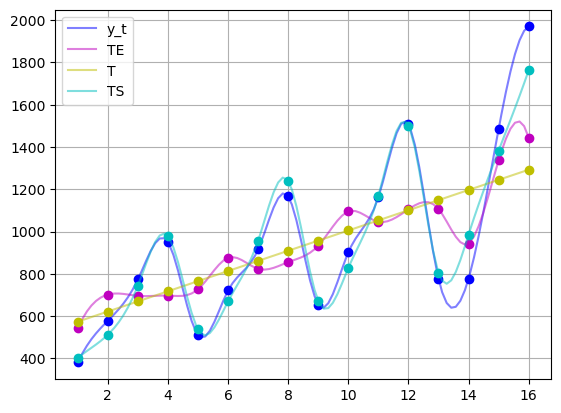

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

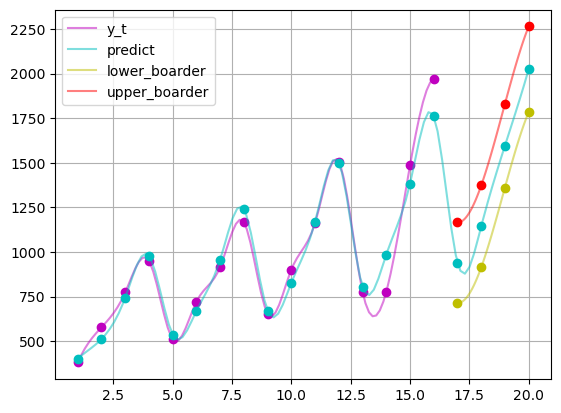

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


                                Данные задания 3                                

--- Аддитивная модель 3_1 ---


<IPython.core.display.Math object>

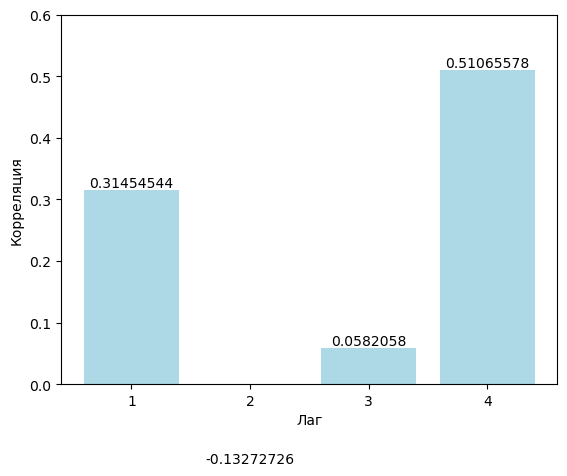

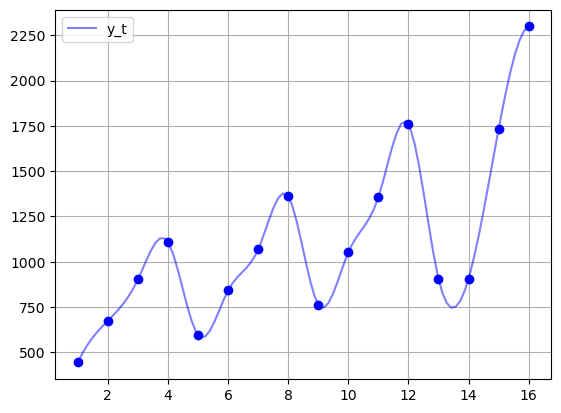

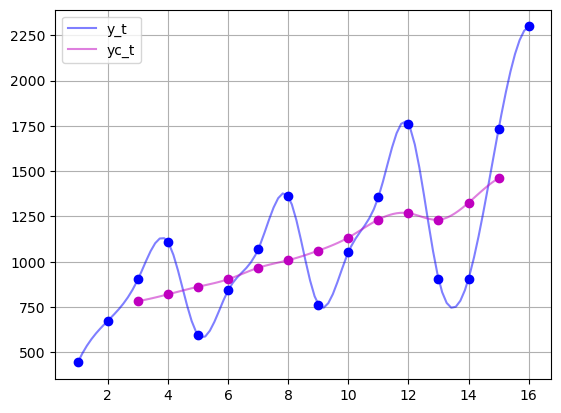

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 608.663541666675
b1 = 59.0476715686265


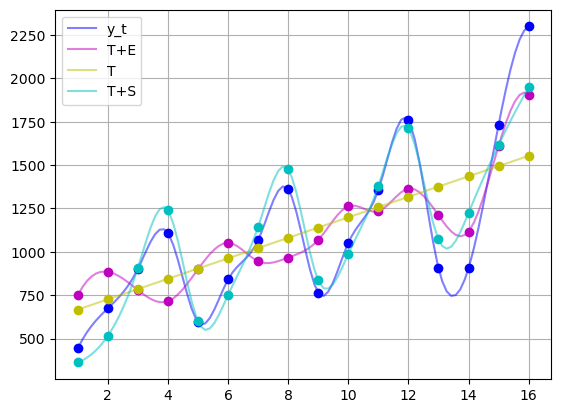

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

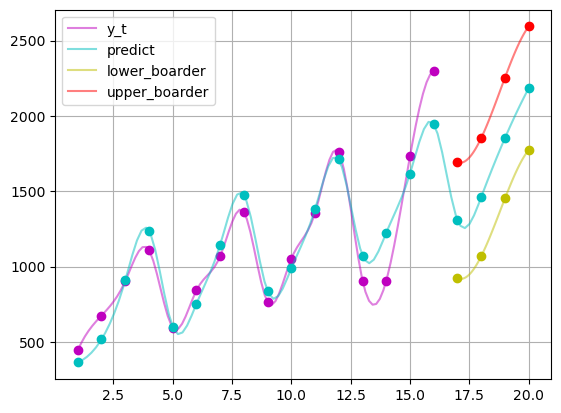

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


--- Мультипликативная модель 3_2 ---


<IPython.core.display.Math object>

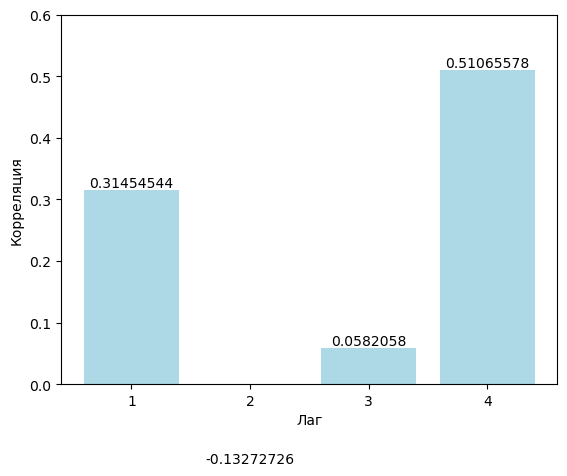

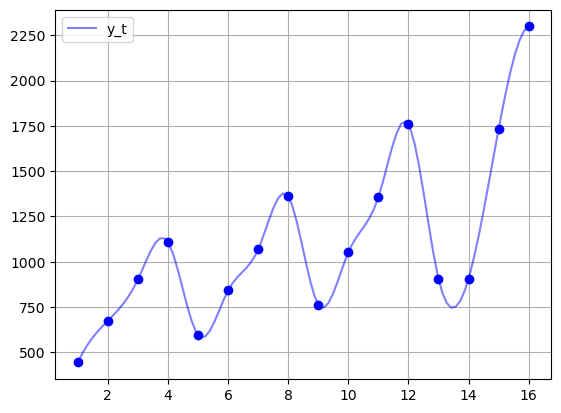

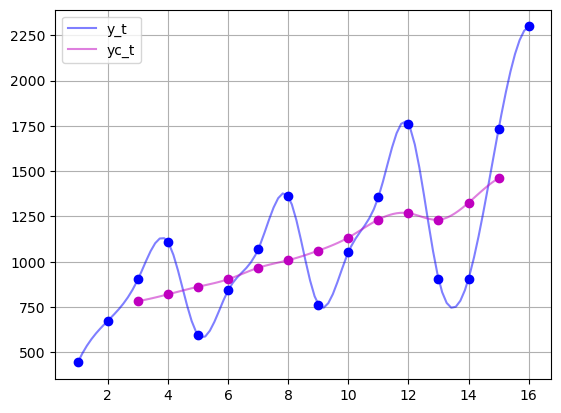

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 613.438795386443
b1 = 55.9104285285413


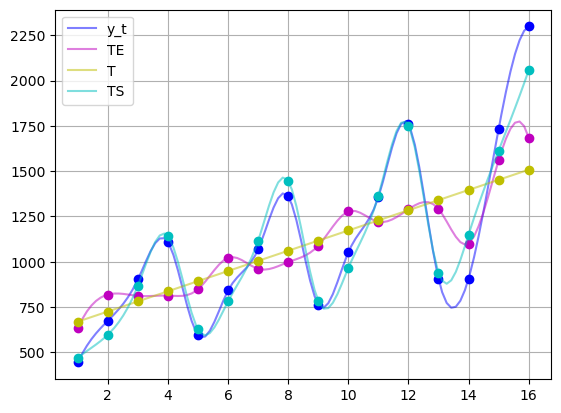

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

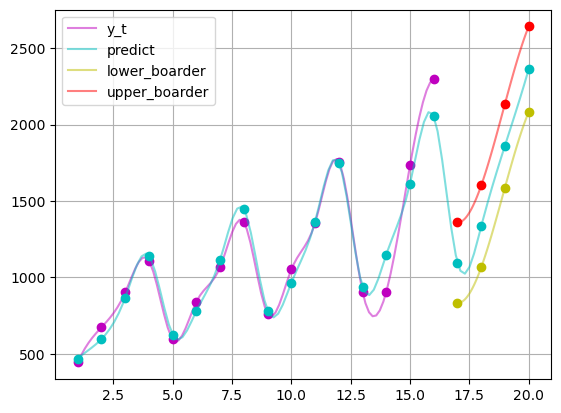

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


                                Данные задания 4                                

--- Аддитивная модель 4_1 ---


<IPython.core.display.Math object>

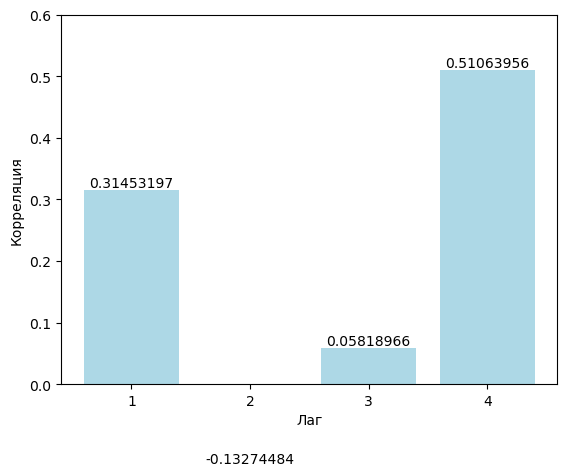

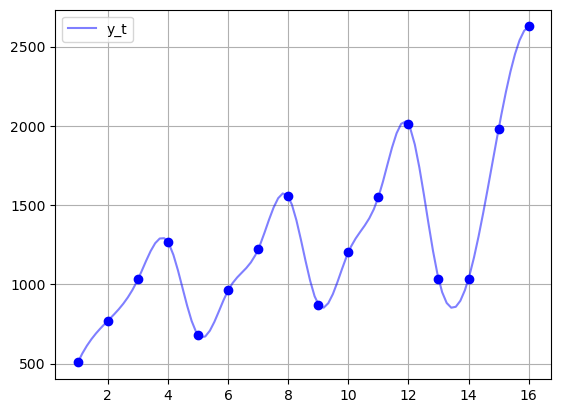

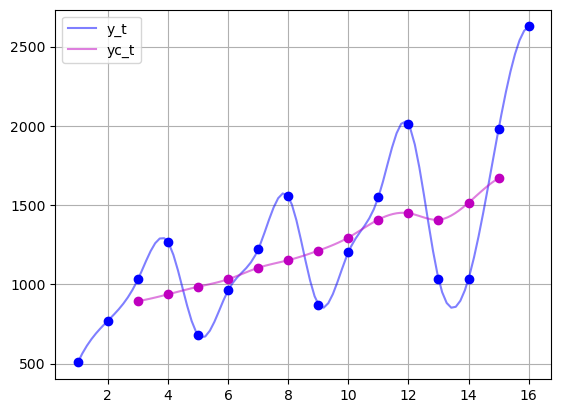

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 695.593750000000
b1 = 67.4830882352941


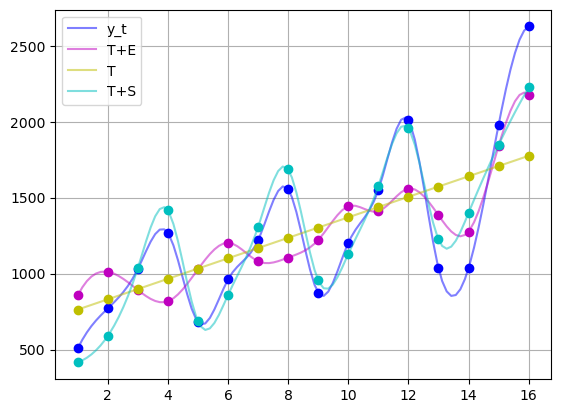

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

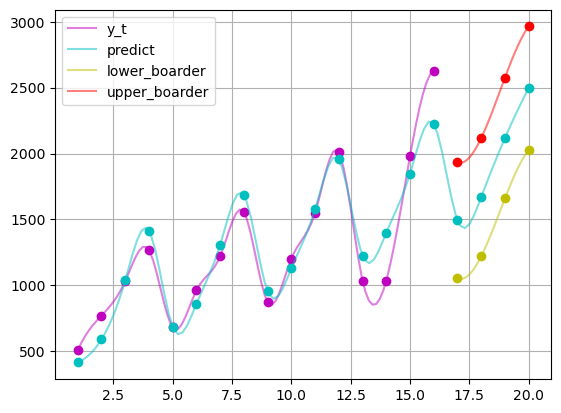

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


--- Мультипликативная модель 4_2 ---


<IPython.core.display.Math object>

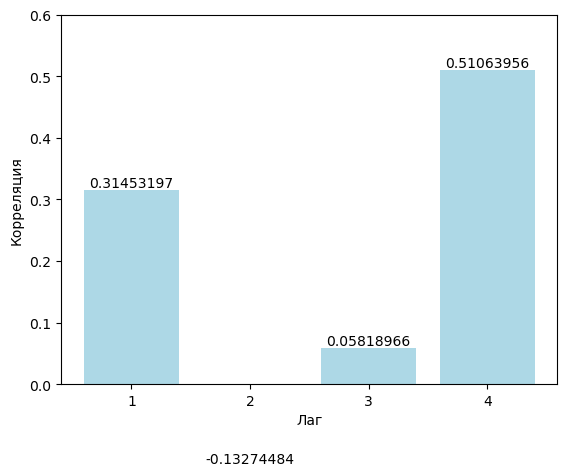

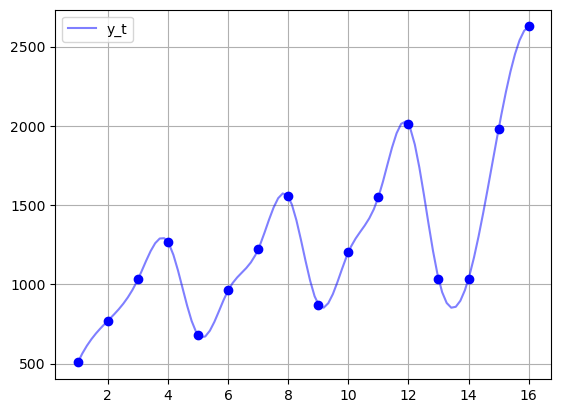

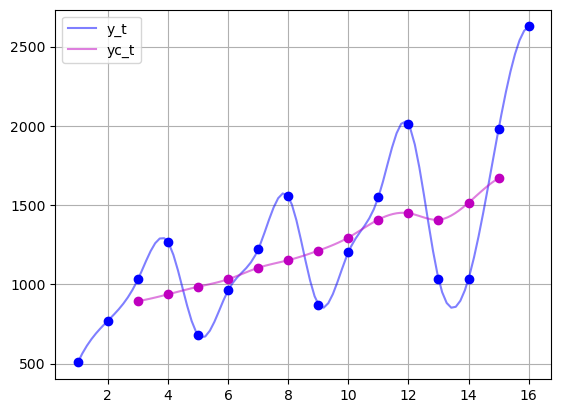

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 701.053657057197
b1 = 63.8970922807628


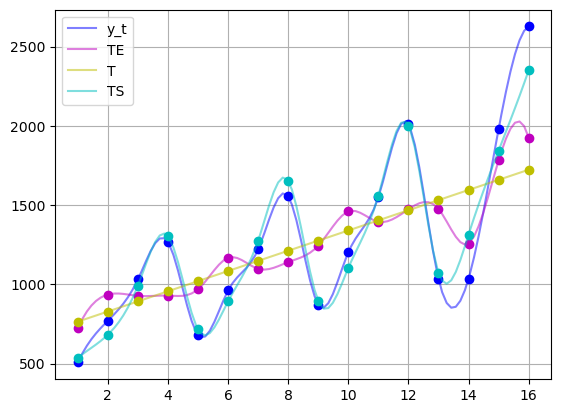

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

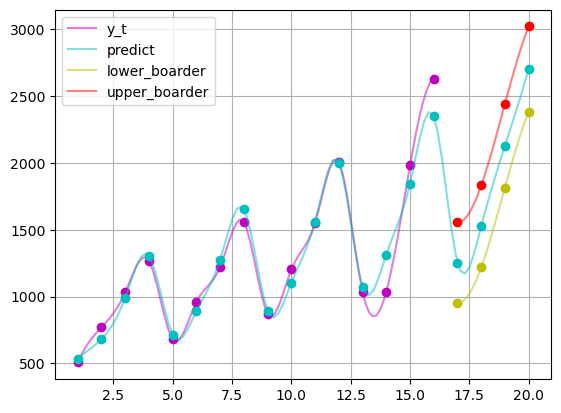

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


                                Данные задания 5                                

--- Аддитивная модель 5_1 ---


<IPython.core.display.Math object>

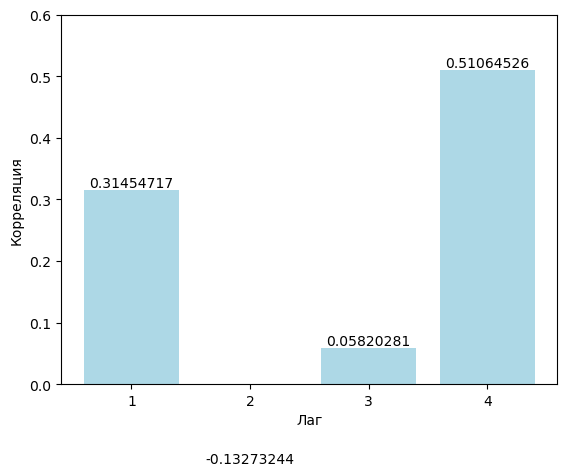

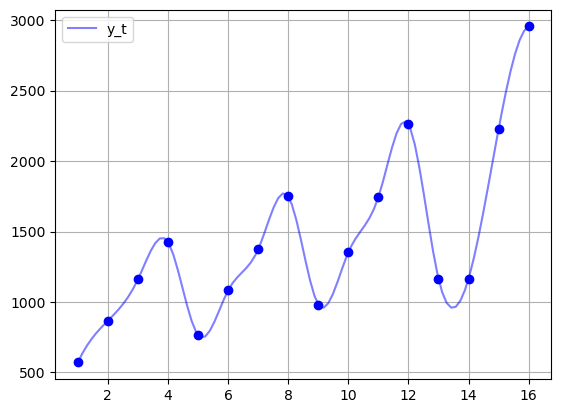

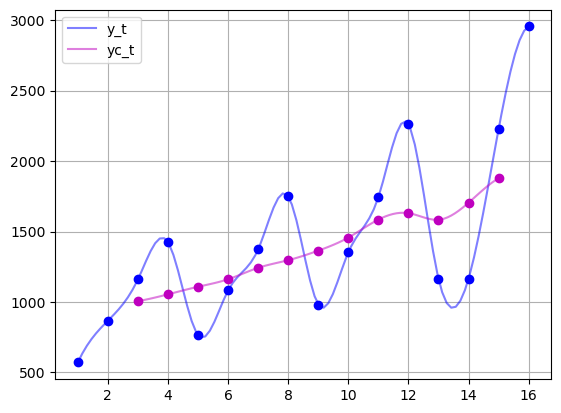

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 782.531875000000
b1 = 75.9212500000000


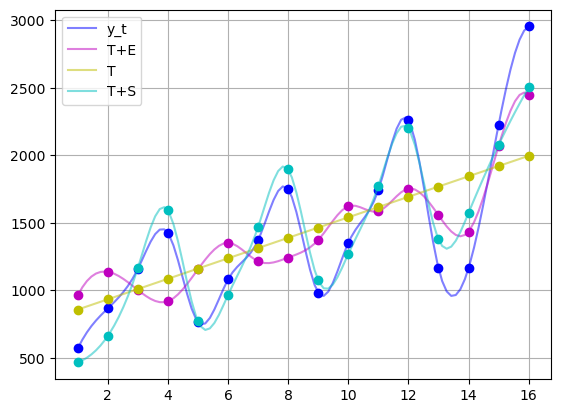

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

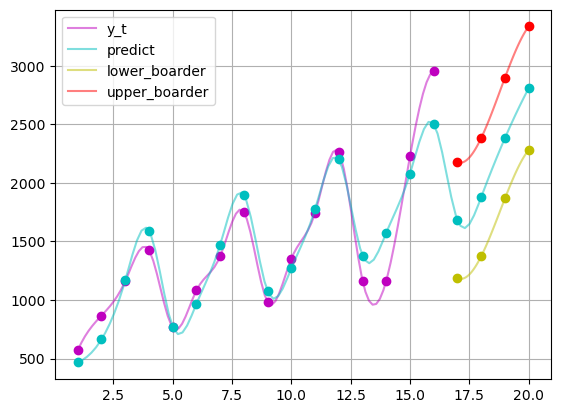

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


--- Мультипликативная модель 5_2 ---


<IPython.core.display.Math object>

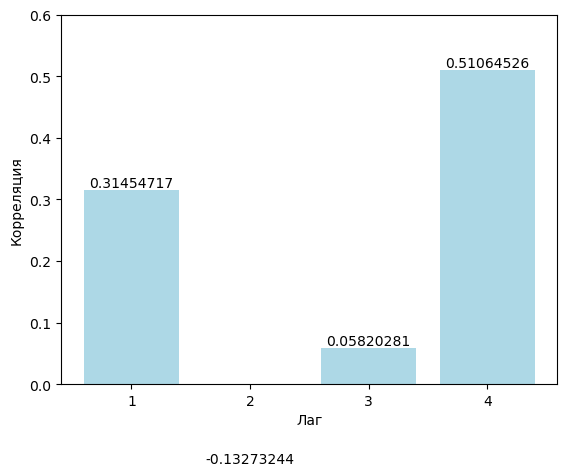

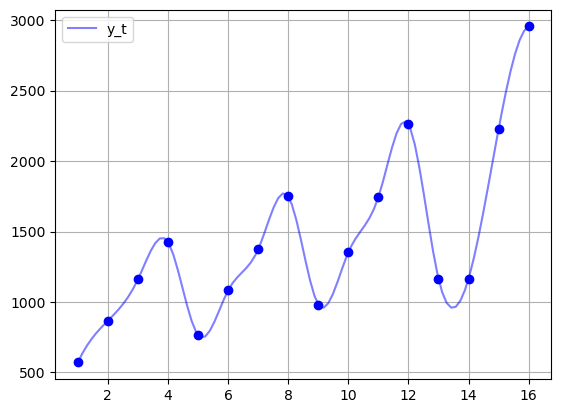

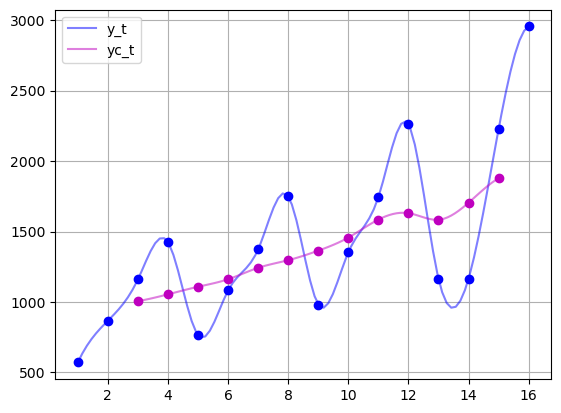

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 788.667247314310
b1 = 71.8877146704665


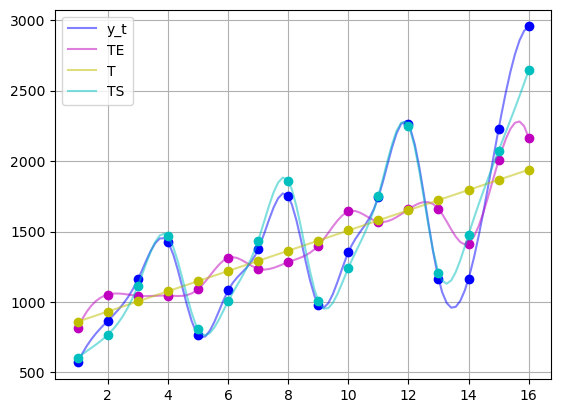

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

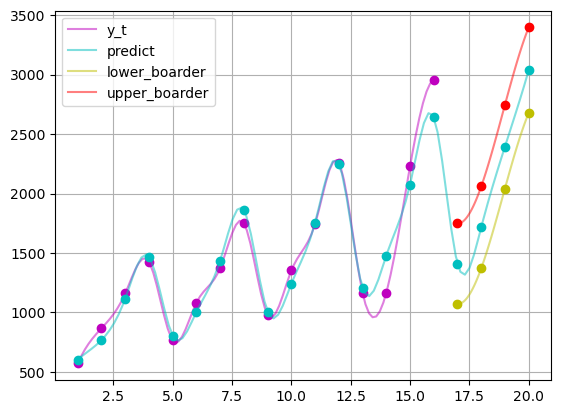

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


                                Данные задания 6                                

--- Аддитивная модель 6_1 ---


<IPython.core.display.Math object>

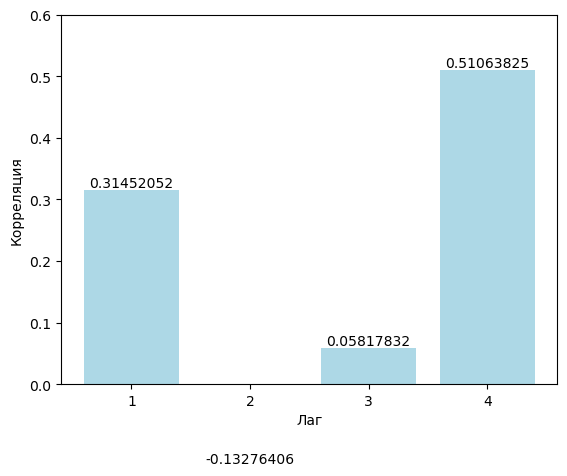

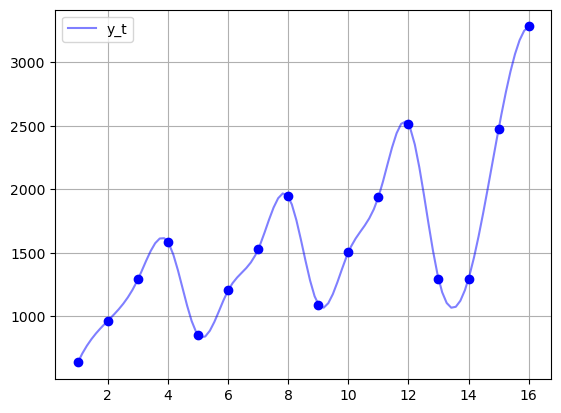

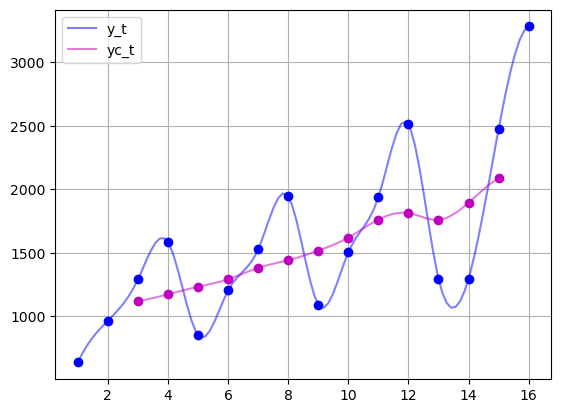

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 869.530625000000
b1 = 84.3515441176471


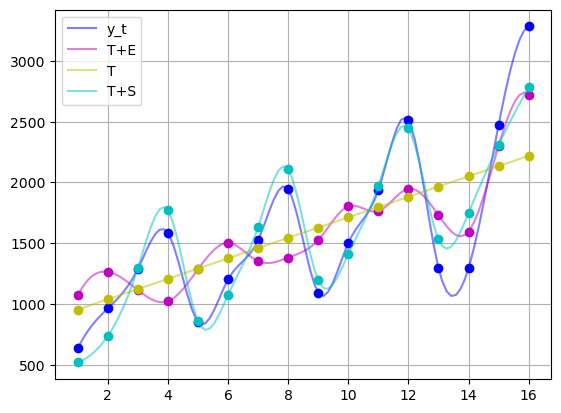

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

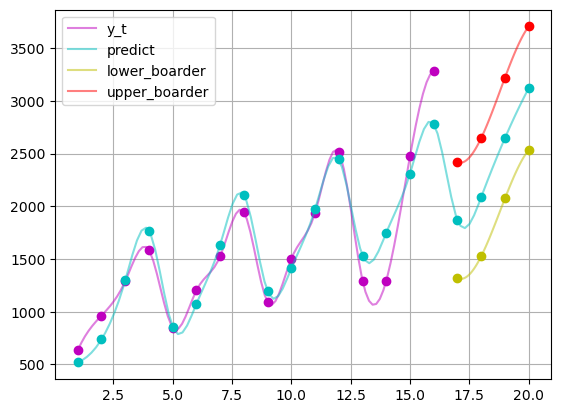

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


--- Мультипликативная модель 6_2 ---


<IPython.core.display.Math object>

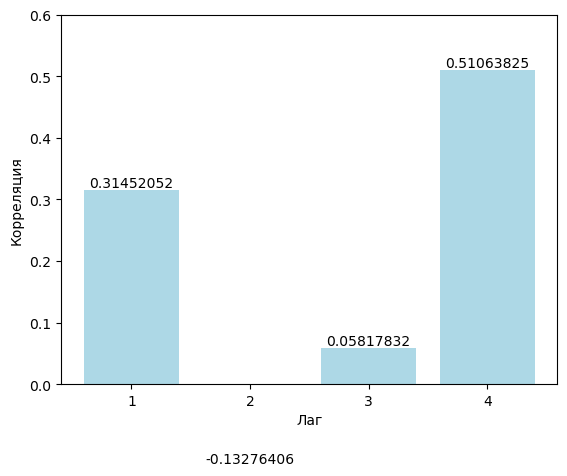

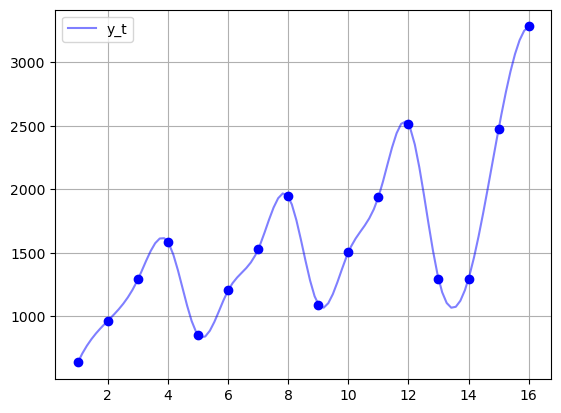

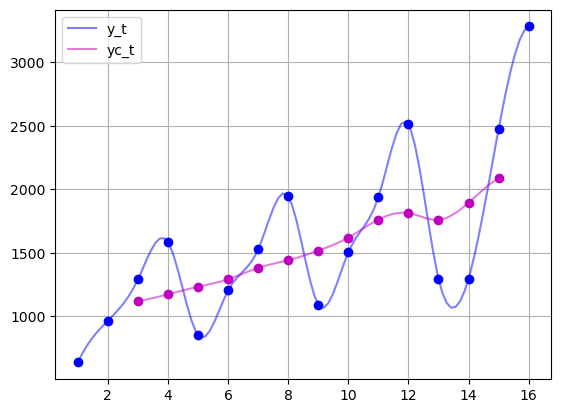

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

b0 = 876.361529651370
b1 = 79.8684493263521


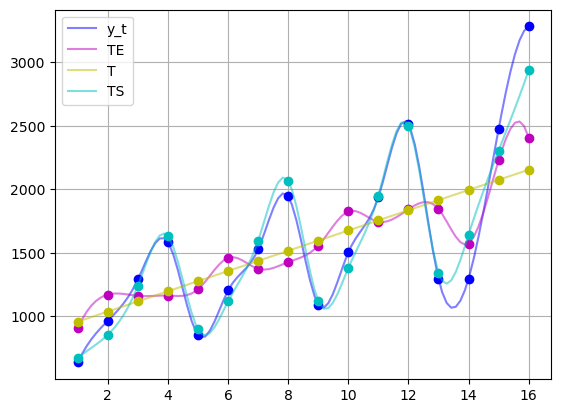

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

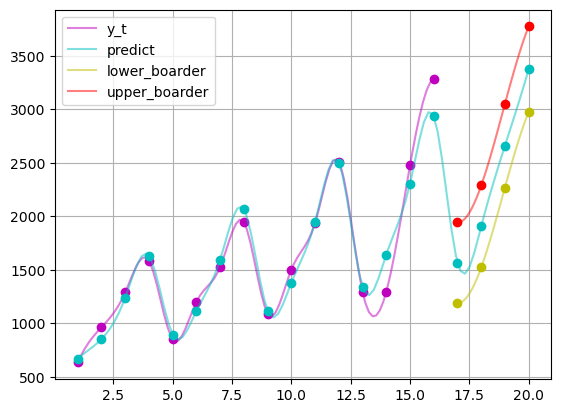

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [24]:
table = 80

organizations.to_excel('organizations2.xlsx')

for i in organizations.columns:
    print(f"\n{'='*table}\n{f'Данные задания {i}':^{table}}\n{'='*table}")
    data = pd.DataFrame(organizations.loc[:,i].values.reshape(4,4), columns=[1,2,3,4],index=[2002,2003,2004,2005] )
    display()
    
    print(f"\n--- Аддитивная модель {i}_1 ---")
    addition_model_auto_reg(data, 1, False)
    
    print(f"\n--- Мультипликативная модель {i}_2 ---")
    multiplication_model_auto_reg(data, 1, False)